In [1]:
import numpy
import scipy.stats
import matplotlib.pyplot
from exp import load_data
import sklearn.model_selection
import utils
from GP_Beta_cal import GP_Beta
from sklearn.isotonic import IsotonicRegression
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Specify the uncalibrated base model and dataset

For base models: 'olr' (ordinary least square), 'deep' (deep nets with drop out approximation), 'br' (bayesian ridge regression), 'gp' (Gaussian process regression)

For datasets: 0. diabetes, 1. boston, 2. arifoil, 3. forest fire, 4.strength, 5.energy

In [2]:
base = 'olr'
dataset = 1

Load the boston dataset and split into training and testing sets.

In [3]:
(x_raw, y_raw) = load_data(dataset, base)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x_raw, y_raw.ravel(),
                                                                            test_size=0.25, shuffle=True)

y_train = y_train.reshape(-1, 1)

y_test = y_test.reshape(-1, 1)

Train a simple linear regression, and obtain its prediction (mean and std).  

In [4]:
base_model = utils.get_mdl(x_train, y_train, base) # change 'olr' to 'deep' / 'br' / 'gp' for other base models

Create a calibration set by collecting model prediction (mean and std).  

In [5]:
mu_cal, sigma_cal = utils.get_prediction(x_train, base_model)

Specify the bins edges to calculate the corresponding PDF / CDF values

In [6]:
n_t_test = 1024

t_list_test = numpy.linspace(numpy.min(mu_cal) - 16.0 * numpy.max(sigma_cal),
                             numpy.max(mu_cal) + 16.0 * numpy.max(sigma_cal),
                             n_t_test).reshape(1, -1)

Train the GP-Beta calibrator

In [7]:
n_u = 8 # number of induced points
GP_Beta_mdl = GP_Beta()
GP_Beta_mdl.fit(y_train, mu_cal, sigma_cal, n_u=n_u)

tf.Tensor([ 1.    1.   -0.83 -0.41  0.    1.    1.    1.  ], shape=(8,), dtype=float64)
tf.Tensor([ 1.00e+00 -1.00e-03  9.99e-01  1.00e-03  9.99e-01 -1.00e-03], shape=(6,), dtype=float64)
Batch: 0, optimiser: adam, Loss: 3.059798704114837
tf.Tensor([ 0.99  0.99 -0.83 -0.42  0.01  0.99  1.01  1.01], shape=(8,), dtype=float64)
tf.Tensor([ 1.01 -0.01  0.99  0.01  0.99 -0.01], shape=(6,), dtype=float64)
Batch: 16, optimiser: adam, Loss: 3.0334264362665837
tf.Tensor([ 0.98  0.98 -0.82 -0.43  0.02  0.98  1.02  1.02], shape=(8,), dtype=float64)
tf.Tensor([ 1.02 -0.02  0.98  0.01  0.98 -0.02], shape=(6,), dtype=float64)
Batch: 32, optimiser: adam, Loss: 3.010289538730453
Previous And Recent Top Averaged Loss Is:
[3.03 2.99]
tf.Tensor([ 0.97  0.97 -0.81 -0.44  0.03  0.97  1.03  1.03], shape=(8,), dtype=float64)
tf.Tensor([ 1.03 -0.03  0.97  0.02  0.97 -0.03], shape=(6,), dtype=float64)
Batch: 48, optimiser: adam, Loss: 2.987930373597681
Previous And Recent Top Averaged Loss Is:
[3.01 2.97]
tf.T

Train the isotonic quantile calibrator

In [8]:
iso_q, iso_q_hat = utils.get_iso_cal_table(y_train, mu_cal, sigma_cal)

iso_mdl = IsotonicRegression(out_of_bounds='clip')

iso_mdl.fit(iso_q, iso_q_hat)

IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                   y_min=None)

Obtain base model prediction on the testing set, as well as predicted PDF and CDF

In [9]:
mu_base, sigma_base = utils.get_prediction(x_test, base_model)

y_base = mu_base.ravel()

q_base, s_base = utils.get_norm_q(mu_base.ravel(), sigma_base.ravel(), t_list_test.ravel())

Apply GP-Beta calibrator to get predicted target value, negtive log-likelihood, PDF and CDF

In [10]:
s_gp, q_gp = GP_Beta_mdl.predict(t_list_test, mu_base, sigma_base)

y_gp = utils.get_y_hat(t_list_test.ravel(), s_gp)

Apply isotonic calibrator to get predicted target value, negtive log-likelihood, PDF and CDF

In [11]:
q_iso = iso_mdl.predict(q_base.ravel()).reshape(numpy.shape(q_base))

s_iso = numpy.diff(q_iso, axis=1) / \
        (t_list_test[0, 1:] - t_list_test[0, :-1]).ravel().reshape(1, -1).repeat(len(y_test), axis=0)

y_iso = utils.get_y_hat(t_list_test.ravel(), s_iso)

Plot PDF / calibration map / CDF for 3 random test instances

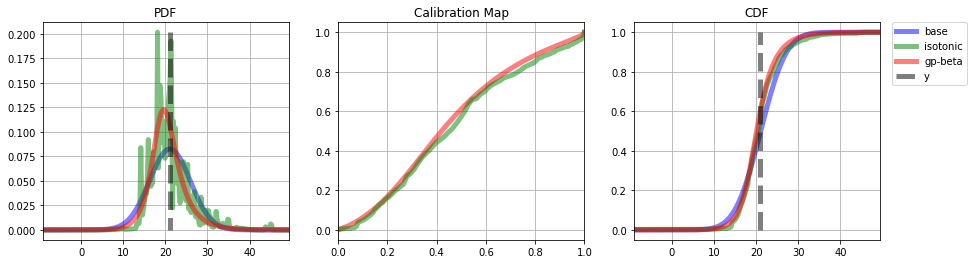

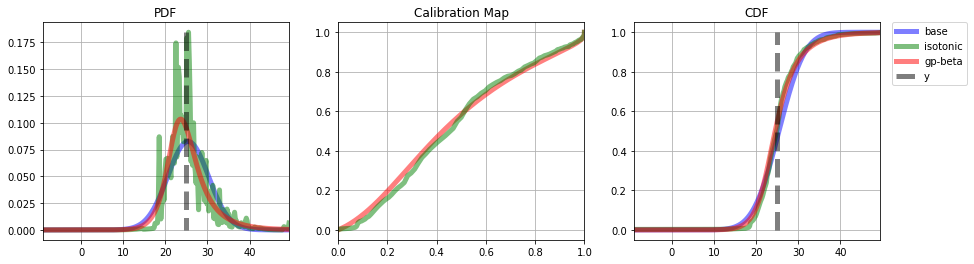

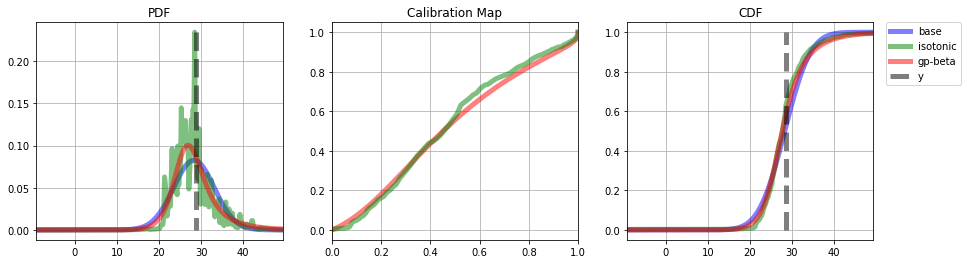

In [12]:
t_list = t_list_test.copy()

y = y_test.copy()

t_list_mid = (t_list[0, 1:] + t_list[0, 0:-1]) / 2

t_list = t_list.ravel()

for i in numpy.random.permutation(numpy.arange(0, len(y)))[:3]:

    fig, ax_list = matplotlib.pyplot.subplots(1, 3, figsize=(15, 4))

    ax_list[2].plot(t_list, q_base[i, :], 'b', alpha=0.5, linewidth=5)

    ax_list[2].plot(t_list, q_iso[i, :], 'g', alpha=0.5, linewidth=5)

    ax_list[2].plot(t_list, q_gp[i, :], 'r', alpha=0.5, linewidth=5)

    ax_list[2].plot([y[i], y[i]], [0, 1], 'k--', linewidth=5, alpha=0.5)

    ax_list[0].plot(t_list, s_base[i, :], 'b', alpha=0.5, linewidth=5)

    ax_list[0].plot(t_list_mid, s_iso[i, :], 'g', alpha=0.5, linewidth=5)

    ax_list[0].plot(t_list, s_gp[i, :], 'r', alpha=0.5, linewidth=5)

    max_density = numpy.max(numpy.concatenate([s_base[i, :].ravel(), s_iso[i, :].ravel(), s_gp[i, :].ravel()]))

    ax_list[0].plot([y[i], y[i]], [max_density, 0], 'k--', linewidth=5, alpha=0.5)

    ax_list[0].set_title('PDF')

    ax_list[1].plot(q_base[i, :], q_gp[i, :], 'r', alpha=0.5, linewidth=5)

    ax_list[1].plot(q_base[i, :], q_iso[i, :], 'g', alpha=0.5, linewidth=5)

    ax_list[0].set_xlim([numpy.min(mu_cal) - numpy.max(sigma_cal), 
                         numpy.max(mu_cal) + numpy.max(sigma_cal)])
    
    ax_list[2].set_xlim([numpy.min(mu_cal) - numpy.max(sigma_cal), 
                         numpy.max(mu_cal) + numpy.max(sigma_cal)])

    ax_list[1].set_xlim([0, 1])

    ax_list[1].set_title('Calibration Map')

    ax_list[2].set_title('CDF')

    ax_list[2].legend(['base', 'isotonic', 'gp-beta', 'y'],
                        bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    ax_list[0].grid(True)

    ax_list[1].grid(True)

    ax_list[2].grid(True)

Evaluate negative log-likelihood, pin-ball loss, and MSE

In [13]:
ll_base = - scipy.stats.norm.logpdf(y_test.reshape(-1, 1),
                                    loc=mu_base.reshape(-1, 1),
                                    scale=sigma_base.reshape(-1, 1)).ravel()
ll_iso = utils.get_log_loss(y_test, t_list_test.ravel(), s_iso)
ll_gp = utils.get_log_loss(y_test, t_list_test.ravel(), s_gp)
print([numpy.mean(ll_base), numpy.mean(ll_iso), numpy.mean(ll_gp)])

[2.8972525066080648, 2.9434830965347096, 2.8280062181281056]


In [14]:
pbl_base = utils.get_pin_ball_loss(y_test, q_base, t_list_test.ravel())
pbl_iso = utils.get_pin_ball_loss(y_test, q_iso, t_list_test.ravel())
pbl_gp = utils.get_pin_ball_loss(y_test, q_gp, t_list_test.ravel())
print([pbl_base[0], pbl_iso[0], pbl_gp[0]])

[159.65335377795031, 157.08977376662105, 154.73078974751581]


In [15]:
se_base = utils.get_se(y_base, y_test)
se_iso = utils.get_se(y_iso, y_test)
se_gp = utils.get_se(y_gp, y_test)
print([numpy.mean(se_base), numpy.mean(se_iso), numpy.mean(se_gp)])

[18.813881661741043, 18.75424307395026, 18.76287316817149]
